In [ ]:
import random
import pandas as pd
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt

In [ ]:
"""
Separate each asset to independent df
"""

raw_data = pd.read_csv("AIDX.csv", encoding='gbk')

# grouped by index code
grouped_asset = raw_data.groupby("S_IRDCODE")

# only keep dataframe that has more than 200 trading dates
asset_dfs = {ird_code: group for ird_code, group in grouped_asset if len(group) >= 200}

# save each asset independently to csv
for ird_code, grouped_df in asset_dfs.items():
    grouped_df['TRADE_DT'] = pd.to_datetime(grouped_df['TRADE_DT'], format='%Y%m%d')
    grouped_df.sort_values(by='TRADE_DT', inplace=True)
    # grouped_df.to_csv(f"assets/{ird_code}.csv", index=False)

In [ ]:
"""
Find the turning point for a df
"""

# my self-defined strategy
def find_turning_point_self(df, direction, n_days=7, fraction_movement=0.01, threshold_day=14, threshold_rate=0.05):
    df = df.reset_index(drop=True)
    record = []
    
    i = 0  # start index
    while i < len(df.index):
        record_i = i
        pattern_find = False
        for n in range(1, n_days+1):
            try:
                current_close = df.loc[i, 'CLOSE']
                ndays_close = df.loc[i+n, 'CLOSE']
                if (ndays_close - current_close) * direction >= (fraction_movement * current_close):
                    pattern_find = True
                    i += n
                    n = 0
            except:
                pass
        if pattern_find:
            start_date = df.loc[record_i, 'TRADE_DT']
            end_date = df.loc[i, 'TRADE_DT']
            start_close = df.loc[record_i, 'CLOSE']
            end_close = df.loc[i, 'CLOSE']
            if (i - record_i) >= threshold_day \
                or (end_close - start_close) * direction >= (threshold_rate * start_close):
                # print(f"Direction: {direction}, Start: {start_date}, End: {end_date}")
                record.append((start_date, end_date))
            else:
                i = record_i
        i += 1
    return record

# moving average strategy
def find_turning_point_ma(df, window_size=30, threshold=0.05, days_after=0):
    df['moving_average'] = df['CLOSE'].rolling(window=window_size).mean()
    df['deviation'] = ((df['CLOSE'] - df['moving_average']) / df['moving_average']).abs()
    df['is_significant_turning_point'] = df['deviation'] > threshold
    significant_turning_points = df[df['is_significant_turning_point']]

    turning_point_periods = []
    for index, row in significant_turning_points.iterrows():
        start_date = row['TRADE_DT']
        current_index = df.index.get_loc(index)
        end_index = min(current_index + days_after, len(df) - 1)
        end_date = df.iloc[end_index]['TRADE_DT']
        turning_point_periods.append((start_date, end_date))

    return turning_point_periods

# hull moving average strategy
def find_turning_point_hma(df, period=30, days_after=0):
    def weighted_moving_average(data, period):
        weights = np.arange(1, period+1)
        return data.rolling(period).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True)
    
    def hull_moving_average(data, period):
        sqrt_period = int(np.sqrt(period))
        wma_2x = weighted_moving_average(data, period // 2)*2
        wma = weighted_moving_average(data, period)
        raw_hma = wma_2x - wma
        hma = weighted_moving_average(raw_hma, sqrt_period)
        return hma
    
    df['HMA'] = hull_moving_average(df['CLOSE'], period)
    df['hma_change'] = df['HMA'].diff()
    df['hma_direction_change'] = df['hma_change'].apply(np.sign).diff().ne(0)
    turning_points = df[df['hma_direction_change']]
    
    turning_point_periods = []
    for index, row in turning_points.iterrows():
        start_date = row['TRADE_DT']
        current_index = df.index.get_loc(index)
        end_index = min(current_index + days_after, len(df) - 1)
        end_date = df.iloc[end_index]['TRADE_DT']
        turning_point_periods.append((start_date, end_date))
    
    return turning_point_periods


In [ ]:
"""
Visualisation
"""

def asset_whole_period_visualisation(ird_code, df, date_record, window_size=30):
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Plotting the moving average
    df['moving_average'] = df['CLOSE'].rolling(window=window_size).mean()
    ax.plot(df['TRADE_DT'], df['moving_average'], label='Moving Average', color='orange', linestyle='--')
    
    line, = ax.plot(df['TRADE_DT'], df['CLOSE'], marker='o',  label='Close Price')
    
    # Special part hightlight
    for start_date, end_date in date_record:
        mask = (df['TRADE_DT'] >= start_date) & (df['TRADE_DT'] <= end_date)
        segment = df.loc[mask]
        ax.plot(segment['TRADE_DT'], segment['CLOSE'], marker='o', color='red', label='Highlighted Period')

    # Title and labels
    ax.set_title(f'{ird_code}')
    ax.set_xlabel('Trade Date')
    ax.set_ylabel('Close Value')
    ax.grid(True)
    plt.xticks(rotation=45)  # Rotate dates for better visibility

    # Annotation for data cursor
    annot = ax.annotate("", xy=(0,0), xytext=(-20,20),
                        textcoords="offset points", 
                        bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)

    def update_annot(ind):
        x, y = line.get_data()
        annot.xy = (x[ind["ind"][0]], y[ind["ind"][0]])
        date = pd.to_datetime(x[ind["ind"][0]]).strftime('%Y-%m-%d')
        text = f"{date}, {y[ind['ind'][0]]:.2f}"
        annot.set_text(text)

    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == ax:
            cont, ind = line.contains(event)
            if cont:
                update_annot(ind)
                annot.set_visible(True)
                fig.canvas.draw_idle()
            else:
                if vis:
                    annot.set_visible(False)
                    fig.canvas.draw_idle()

    fig.canvas.mpl_connect("motion_notify_event", hover)
    
    # Avoid duplicate labels in the legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.tight_layout()
    plt.show()
    return

In [ ]:
"""
Selection
"""

def select_asset(ird_code, df, fraction_movement=0.01, threshold_day=22, n_days=7, threshold_rate=0.05, start_date='20230901'):
    date_record_up = find_turning_point_self(
        df, direction=1, fraction_movement=fraction_movement, threshold_day=threshold_day, n_days=n_days, threshold_rate=threshold_rate)
    
    date_record_down = find_turning_point_self(
        df, direction=-1, fraction_movement=fraction_movement, threshold_day=threshold_day, n_days=n_days, threshold_rate=threshold_rate)
    
    def filter_periods_by_start(periods, target_start, tolerance_days=5):
        target_start = pd.to_datetime(target_start)
        start_range = target_start - pd.Timedelta(days=tolerance_days)
        end_range = target_start + pd.Timedelta(days=tolerance_days)
        
        qualified_periods = []
        for start, end in periods:
            start = pd.to_datetime(start)
            end = pd.to_datetime(end)
            if start_range <= start <= end_range:
                qualified_periods.append((start, end))
        
        return qualified_periods
    
    up_periods = filter_periods_by_start(date_record_up, target_start=start_date)
    down_periods = filter_periods_by_start(date_record_down, target_start=start_date)
    
    def add_close_to_periods(df, periods):
        df['TRADE_DT'] = pd.to_datetime(df['TRADE_DT'])
        if df.index.name != 'TRADE_DT':
            df = df.set_index('TRADE_DT', drop=False)
        
        enhanced_periods = []
        for start, end in periods:
            start_close = df.at[start, 'CLOSE'] if start in df.index else None
            end_close = df.at[end, 'CLOSE'] if end in df.index else None
            start_str = start.strftime('%Y-%m-%d') if start_close is not None else None
            end_str = end.strftime('%Y-%m-%d') if end_close is not None else None
            enhanced_period = ((start_str, start_close), (end_str, end_close))
            enhanced_periods.append(enhanced_period)
        
        return enhanced_periods
    
    enhanced_up_periods = add_close_to_periods(df=df, periods=up_periods)
    enhanced_down_periods = add_close_to_periods(df=df, periods=down_periods)
    
    if len(up_periods) > 0:
        print(enhanced_up_periods)
        asset_whole_period_visualisation(ird_code=ird_code, df=df, date_record=up_periods)
    if len(down_periods) > 0:
        print(enhanced_down_periods)
        asset_whole_period_visualisation(ird_code=ird_code, df=df, date_record=down_periods)
    
    return enhanced_up_periods, enhanced_down_periods

0
0
[(('2023-09-04', 3110.1343), ('2023-09-20', 2902.0058))]


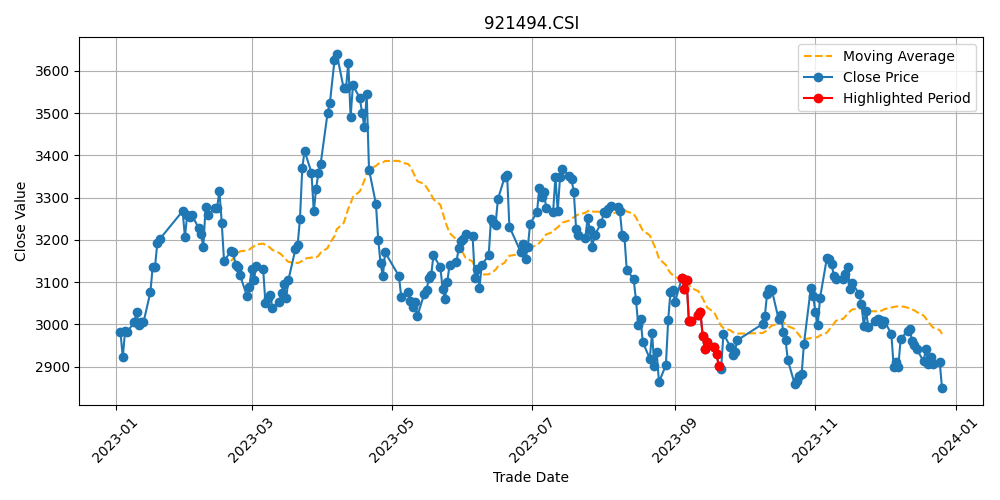

1
1
[(('2023-09-04', 1802.7251), ('2023-09-18', 1708.1047))]


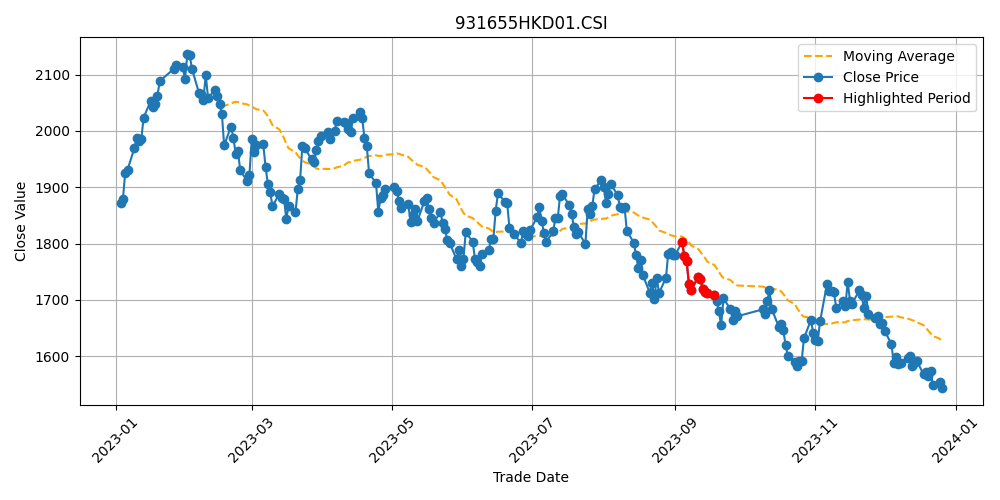

2
[(('2023-09-04', 1432.5504), ('2023-10-10', 1255.2624))]


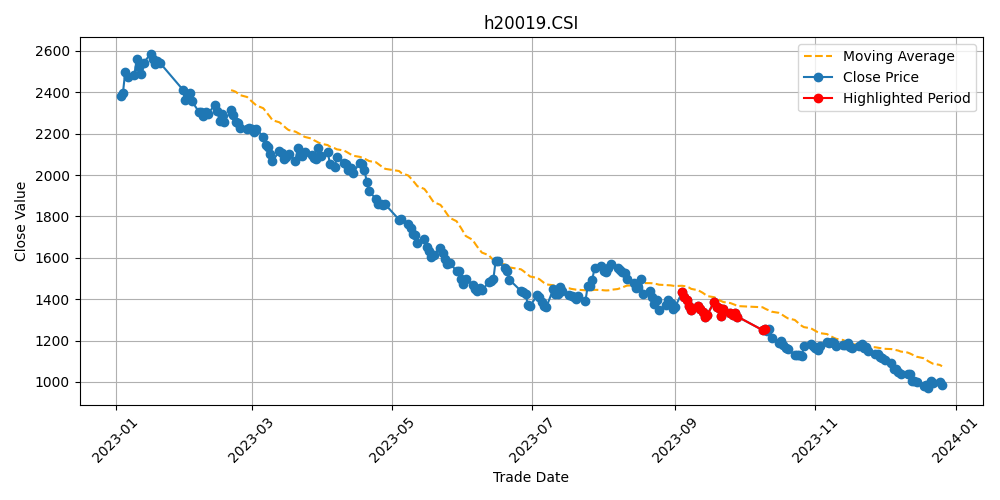

3
3
3
[(('2023-08-30', 2106.0235), ('2023-09-18', 1976.5135))]


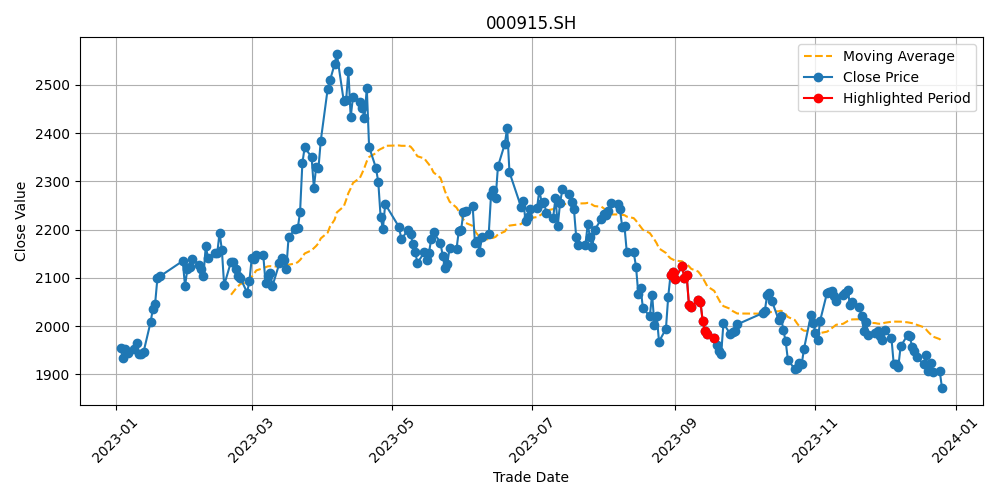

4
4
4
[(('2023-09-04', 3487.3863), ('2023-09-20', 3248.9725))]


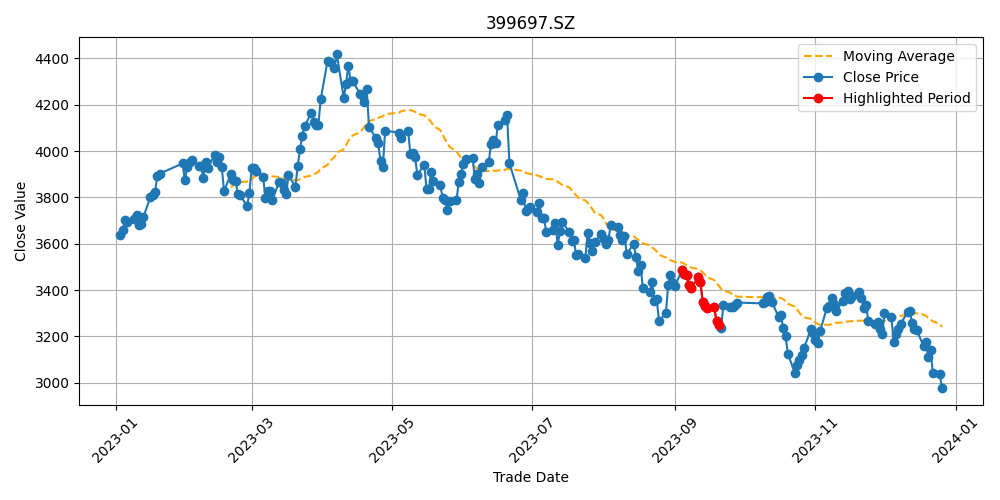

5
5
5
5
5
[(('2023-09-06', 2630.5687), ('2023-10-12', 2858.4642))]


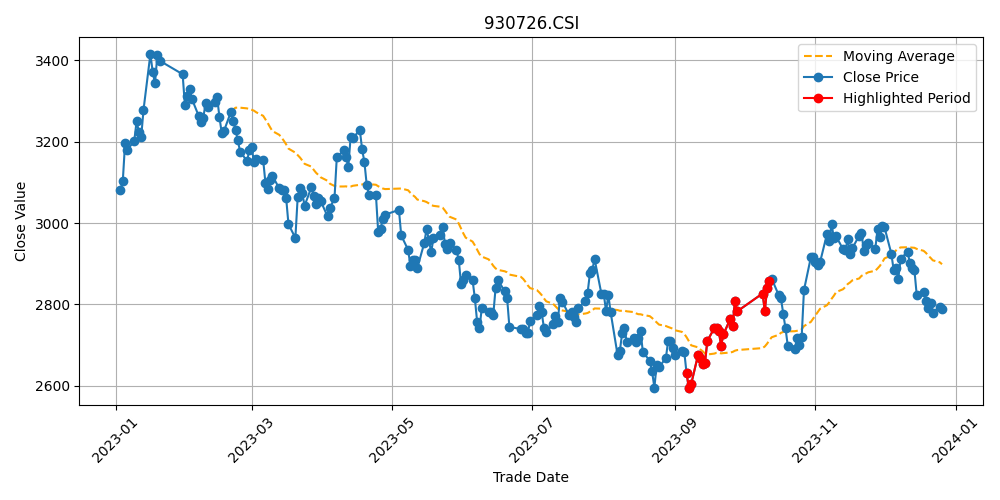

6
[(('2023-09-05', 12392.5255), ('2023-10-09', 13022.6416))]


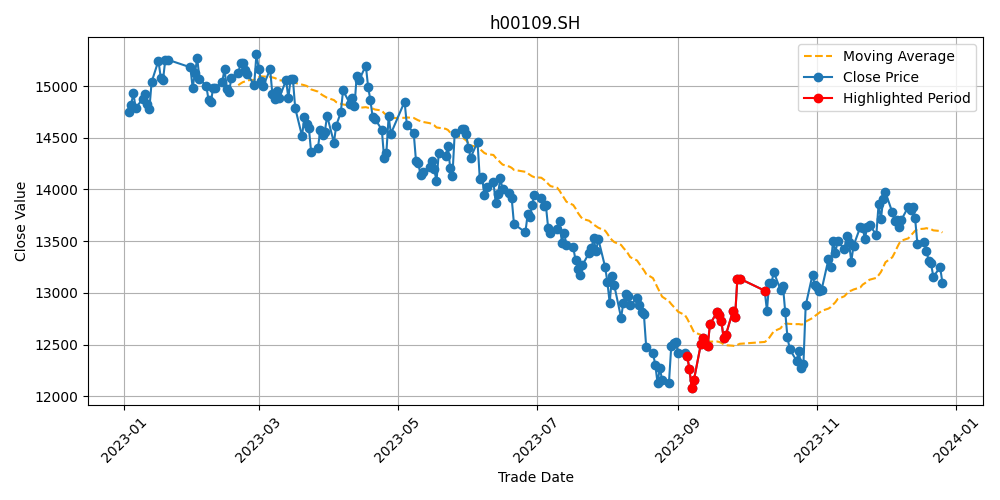

7
[(('2023-08-31', 1322.5191), ('2023-09-26', 1236.5862))]


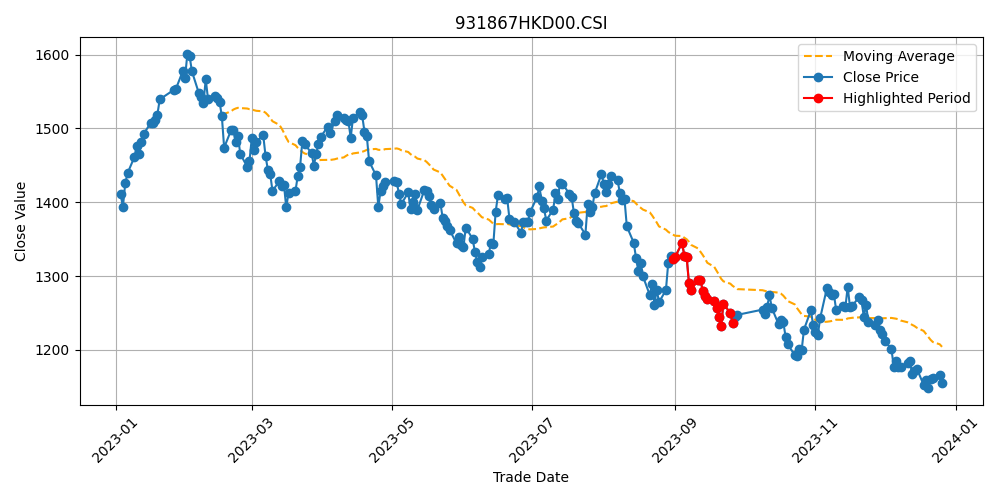

8
8
[(('2023-08-31', 1371.6348), ('2023-09-26', 1290.1782))]


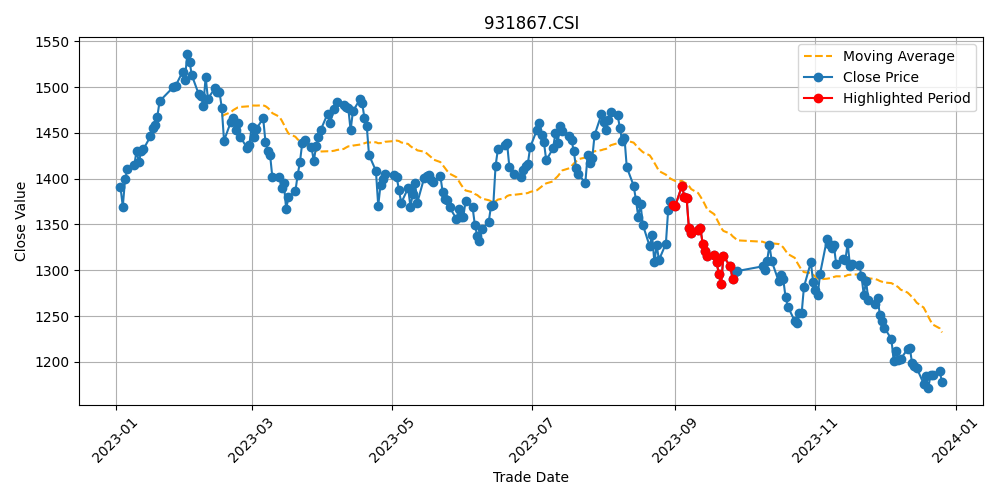

9
9
[(('2023-08-30', 15296.9367), ('2023-09-25', 14030.0951))]


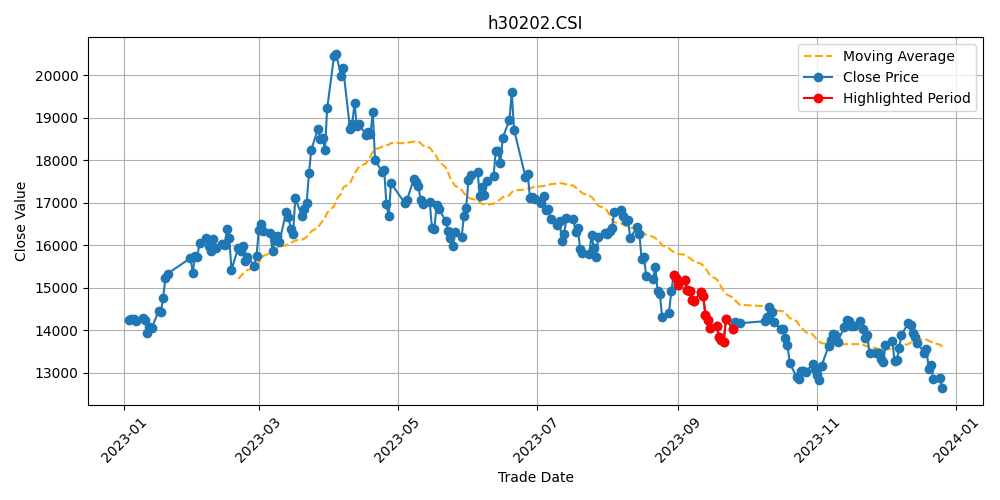

10
[(('2023-08-30', 2158.1858), ('2023-09-15', 2005.838))]


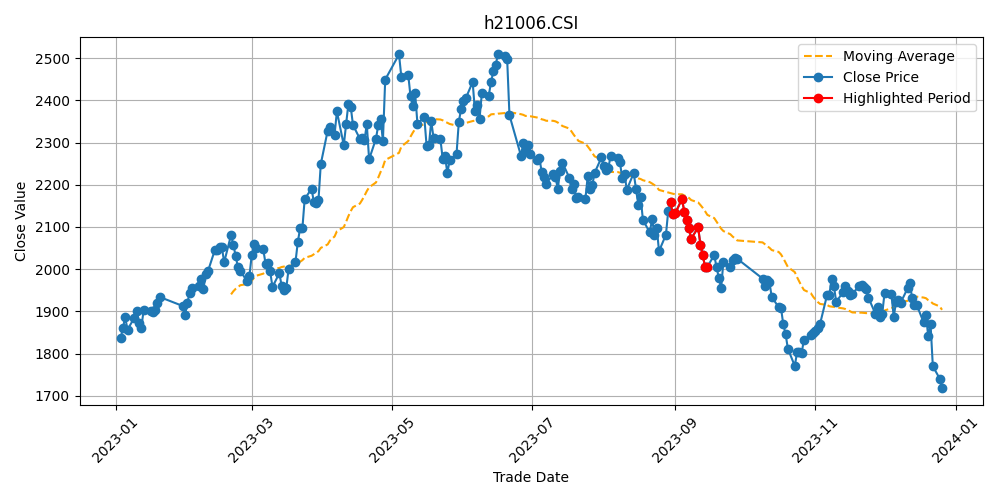

11
[(('2023-09-06', 10215.169), ('2023-09-25', 9598.1613))]


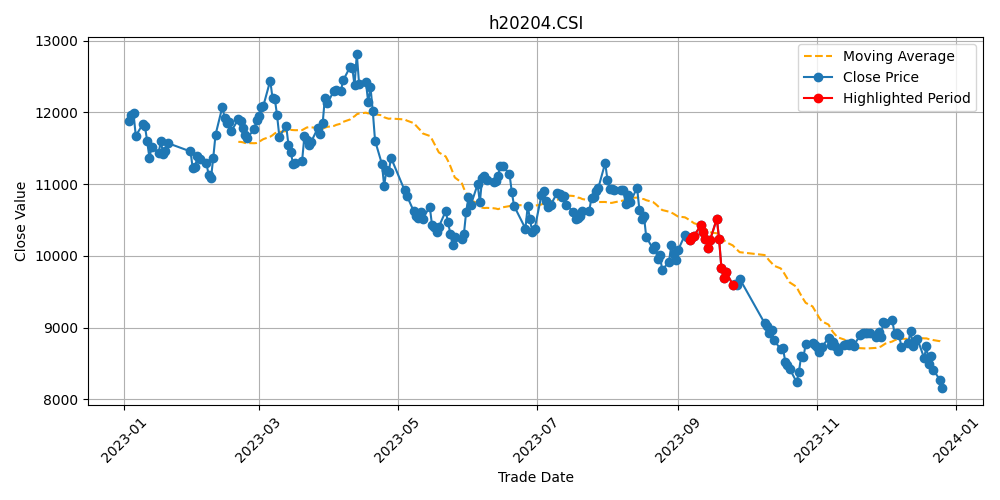

12
[(('2023-09-04', 3281.5904), ('2023-09-20', 3073.3374))]


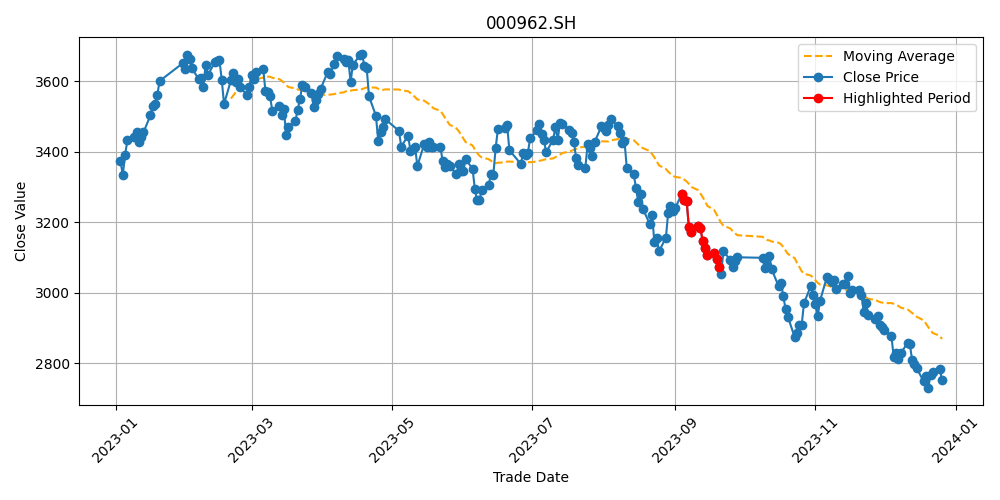

13
[(('2023-09-01', 947.7234), ('2023-09-25', 898.3628))]


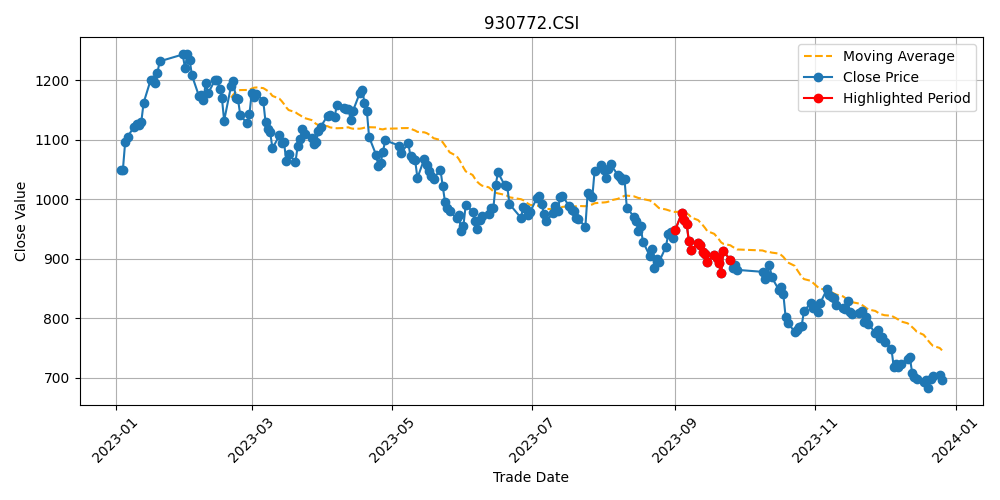

14
14
14
14
[(('2023-09-04', 16093.0572), ('2023-09-26', 15239.6417))]


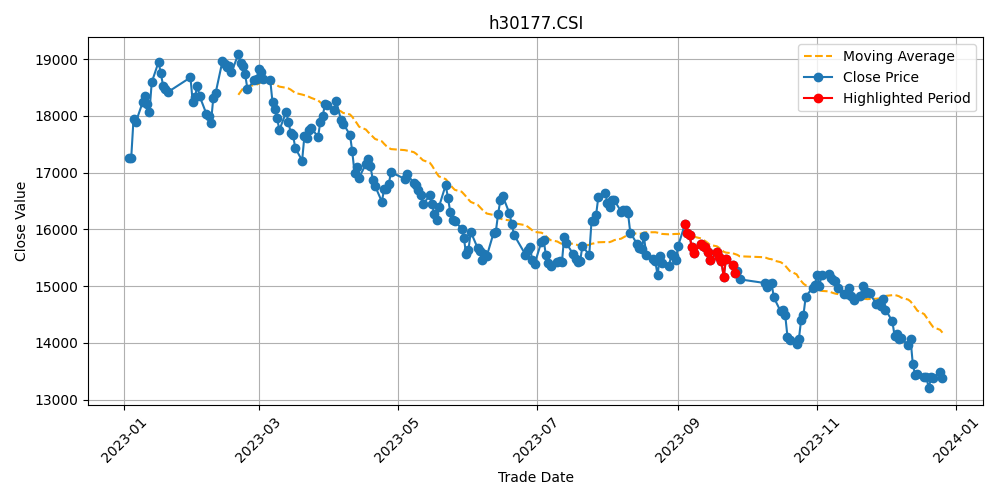

15
15
15
[(('2023-09-06', 2669.6114), ('2023-09-20', 2519.383))]


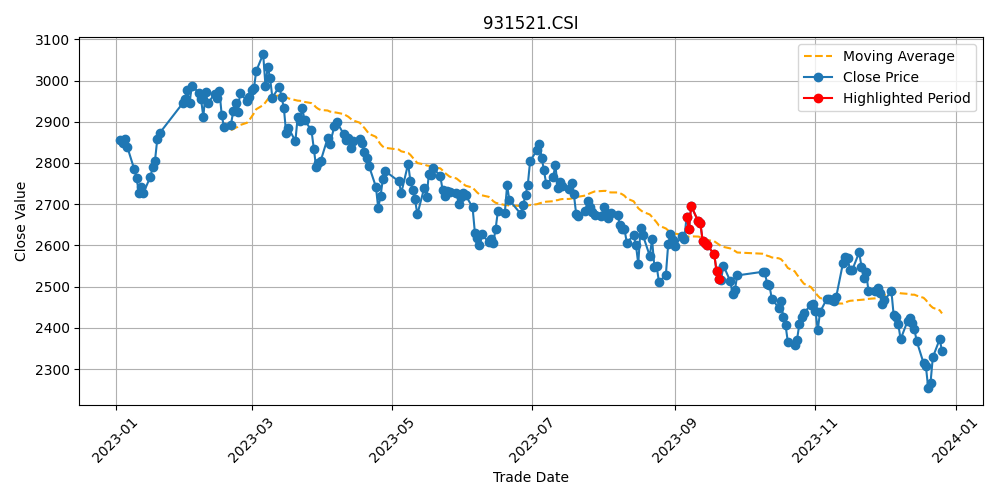

16
16
16
16
16
16
16
16
16
[(('2023-09-04', 2151.6418), ('2023-10-09', 1970.0424))]


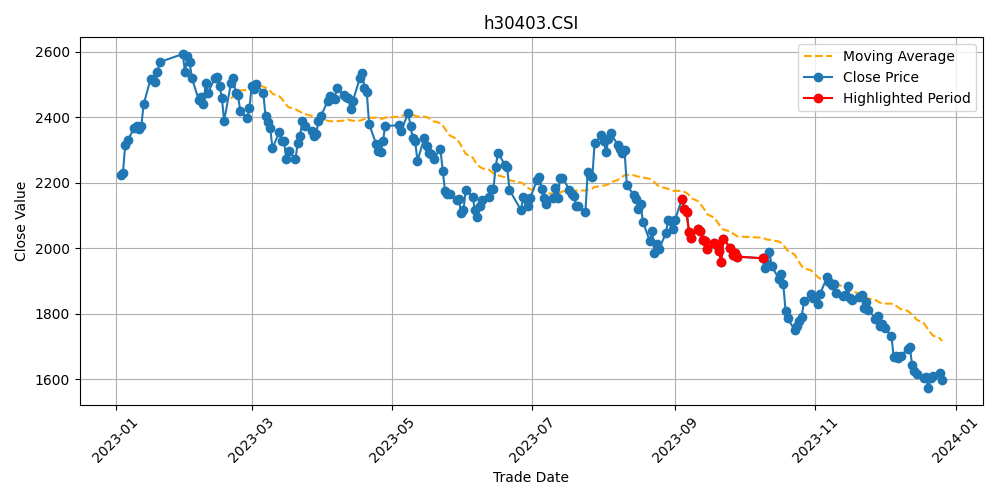

17
[(('2023-09-06', 1275.8574), ('2023-09-25', 1209.0378))]


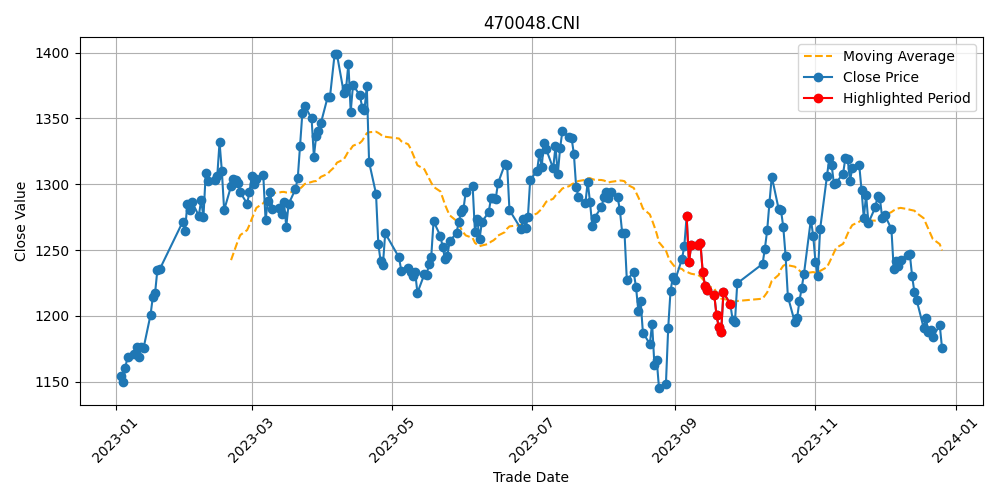

18
[(('2023-08-30', 3455.9404), ('2023-09-18', 3221.8499))]


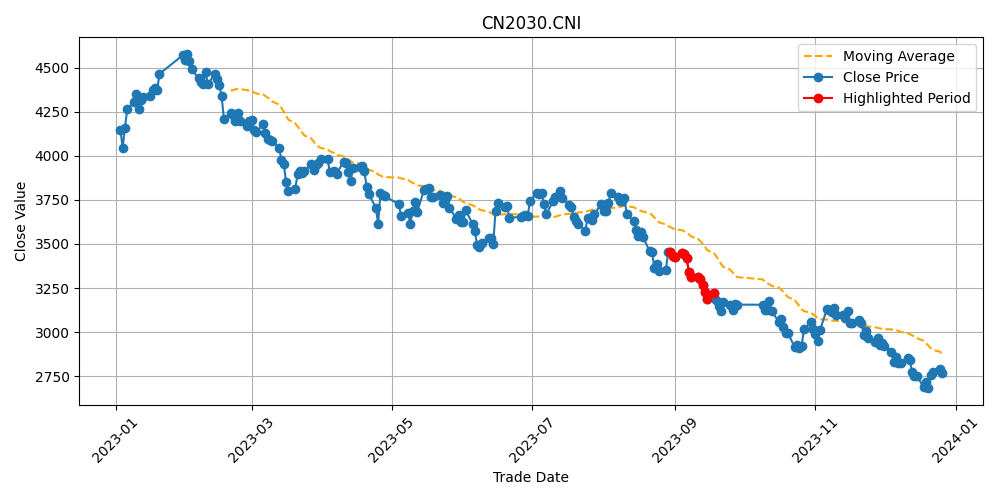

19
[(('2023-08-30', 2558.5044), ('2023-09-18', 2430.4055))]


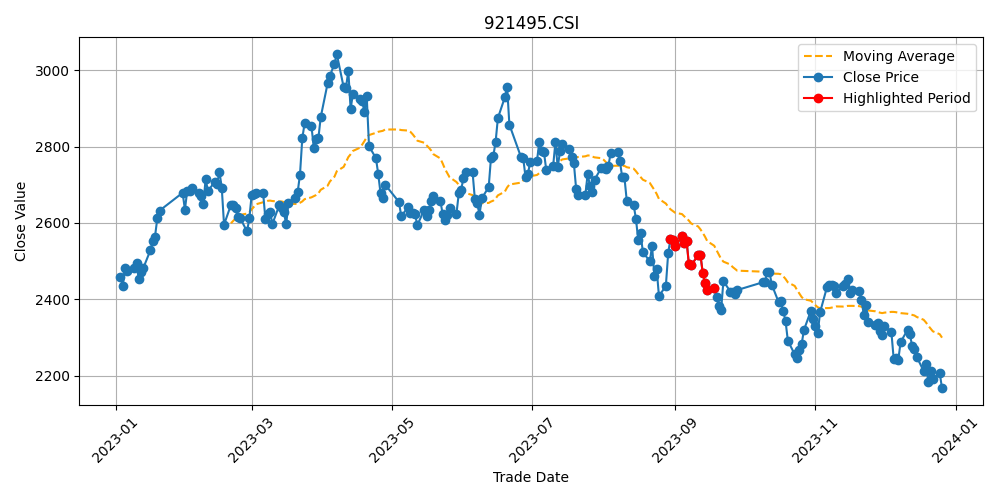

20
20
20
20
20
20
[(('2023-08-29', 802.8264), ('2023-09-01', 761.9522))]


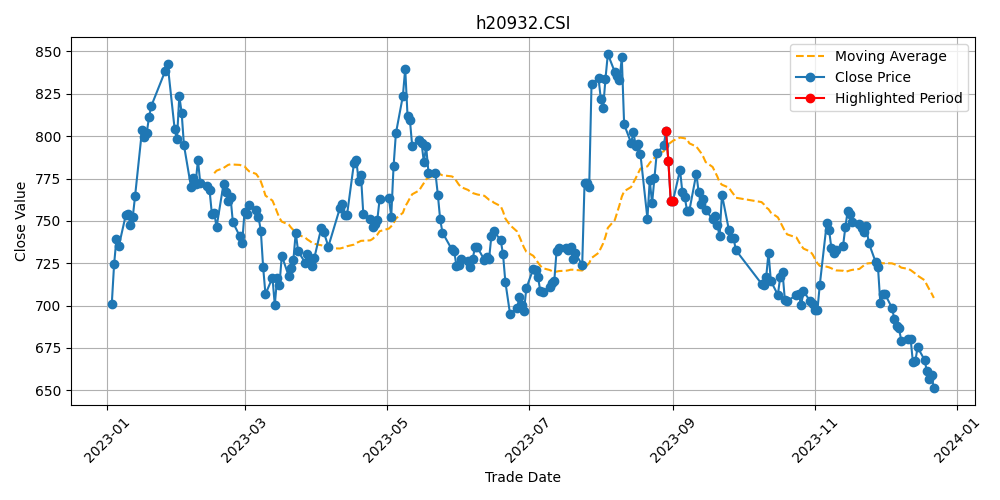

21
21
21
21
[(('2023-09-06', 6314.9788), ('2023-10-12', 6687.3964))]


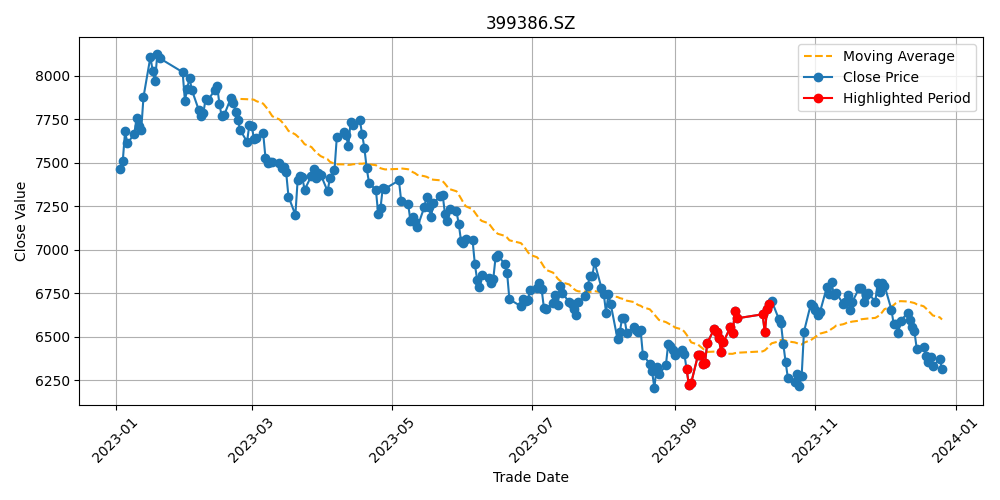

22
[(('2023-08-29', 4791.7017), ('2023-09-26', 4239.3366))]


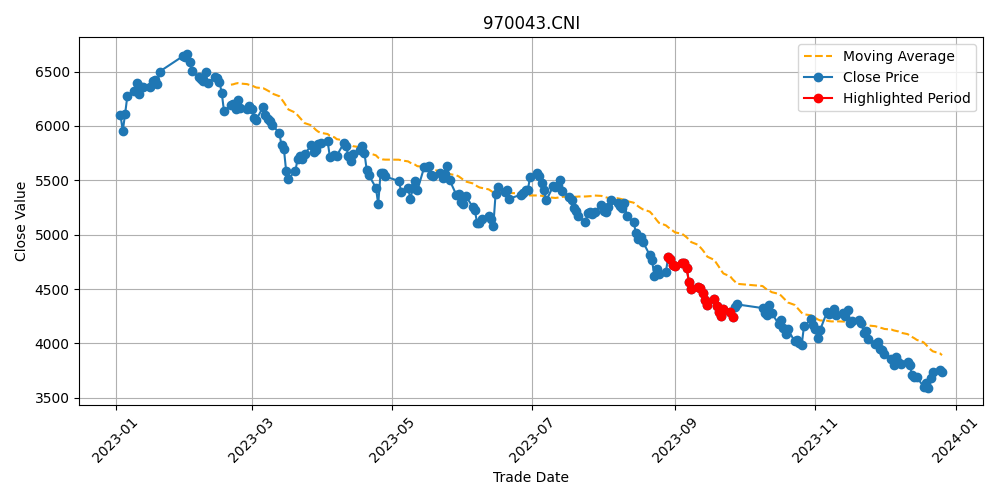

23
[(('2023-08-30', 1527.0952), ('2023-09-20', 1433.4499))]


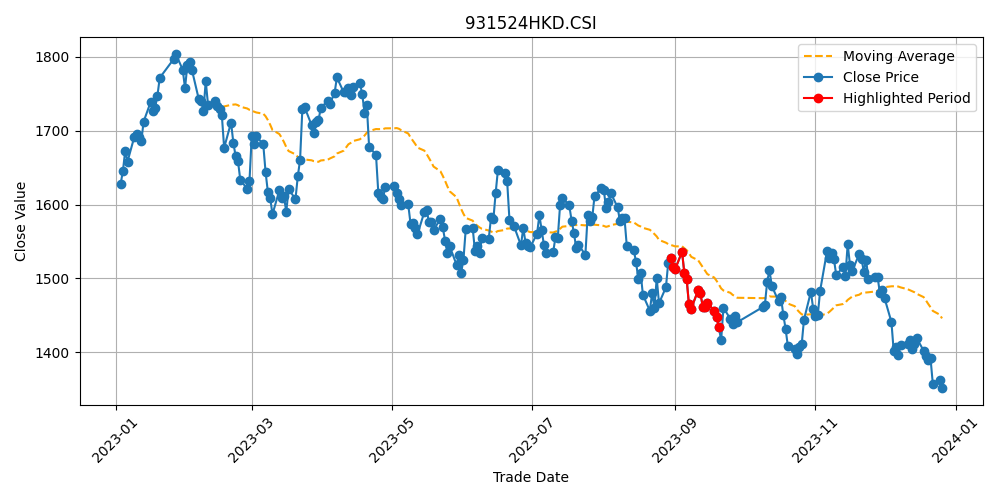

24
24
24
24
[(('2023-08-30', 3952.7028), ('2023-09-14', 3728.7651))]


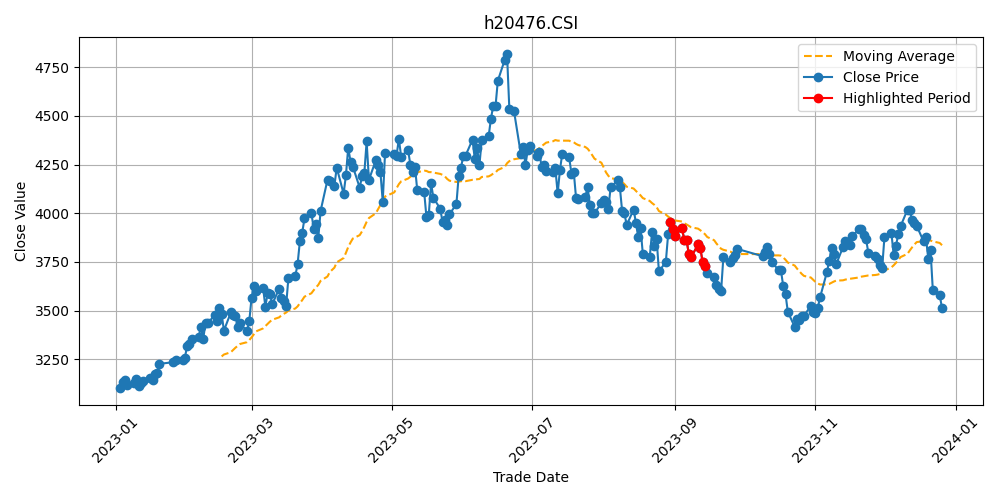

25
25
[(('2023-09-04', 3092.5339), ('2023-10-13', 2552.5852))]


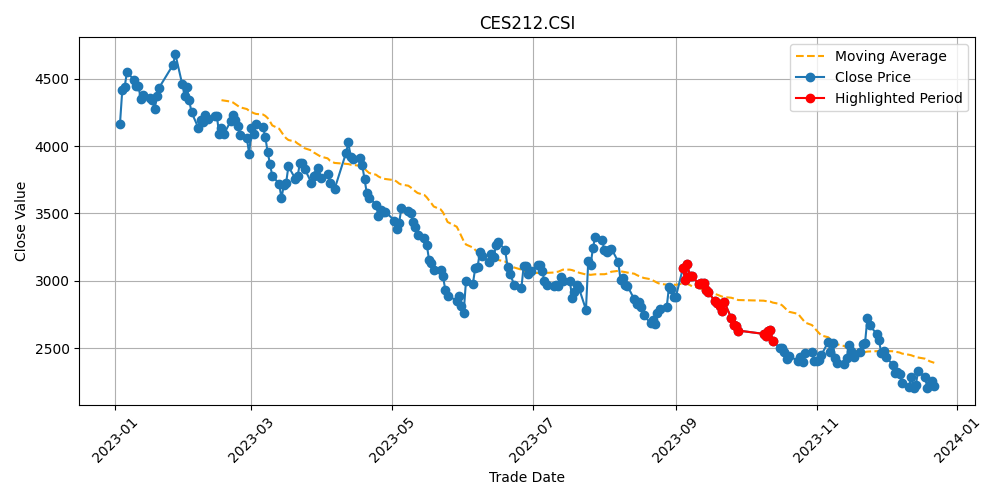

26
[(('2023-09-04', 5253.2295), ('2023-09-15', 4985.6626))]


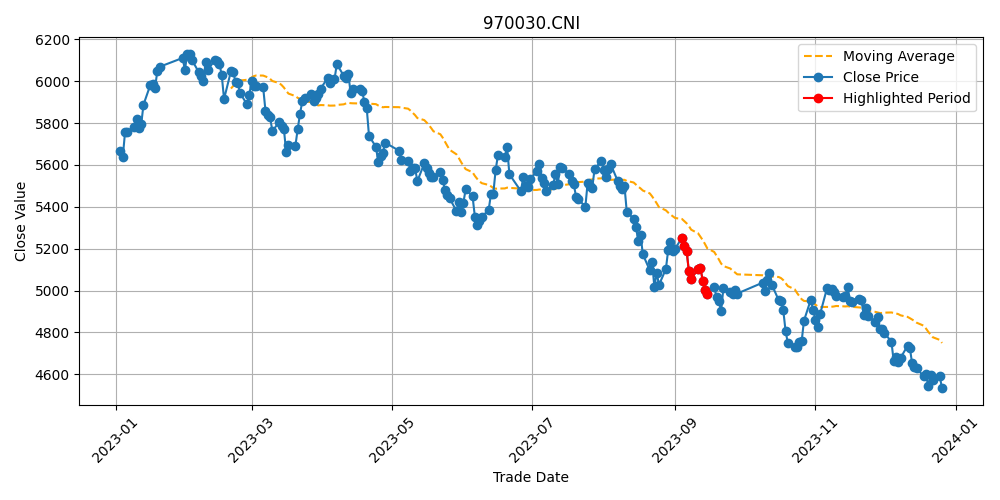

27
27
27
[(('2023-08-29', 1901.1967), ('2023-09-26', 1737.181))]


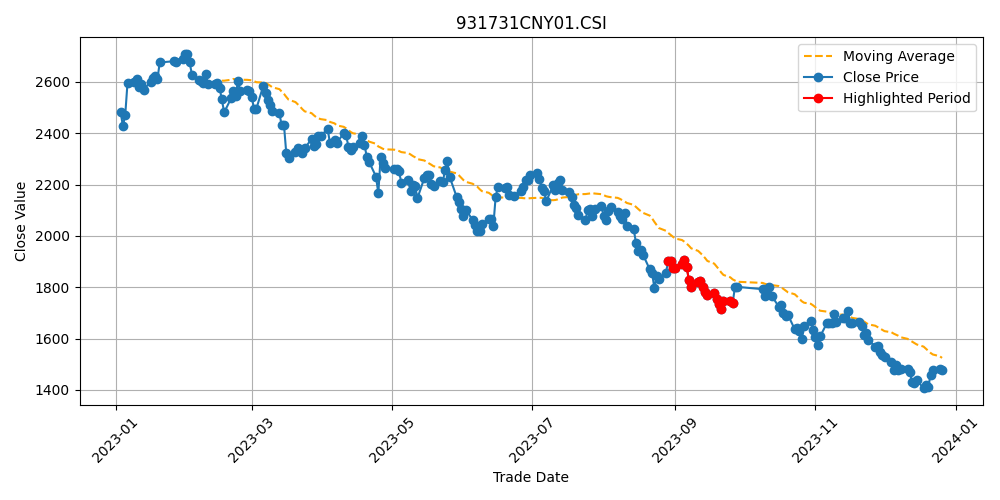

28
28
28
[(('2023-08-31', 1371.6348), ('2023-09-26', 1290.1782))]


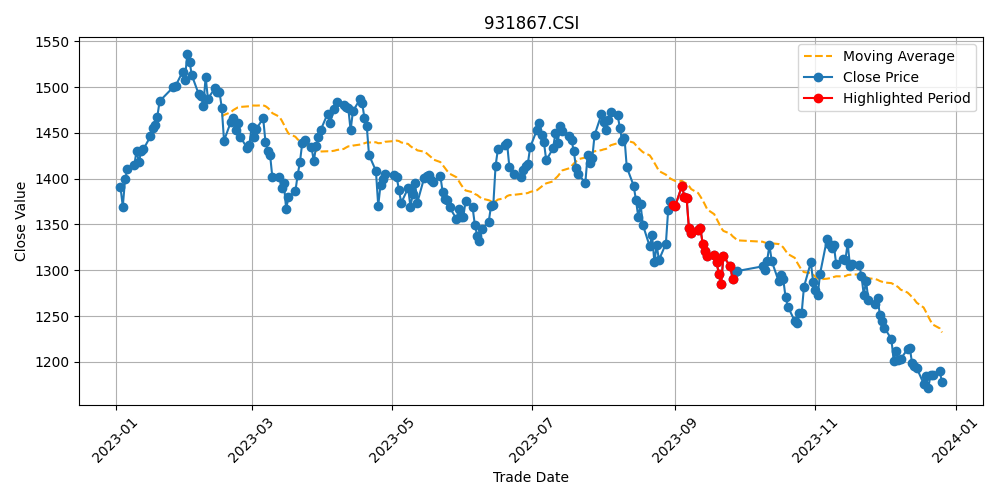

29
[(('2023-09-06', 10998.5824), ('2023-10-12', 11736.9186))]


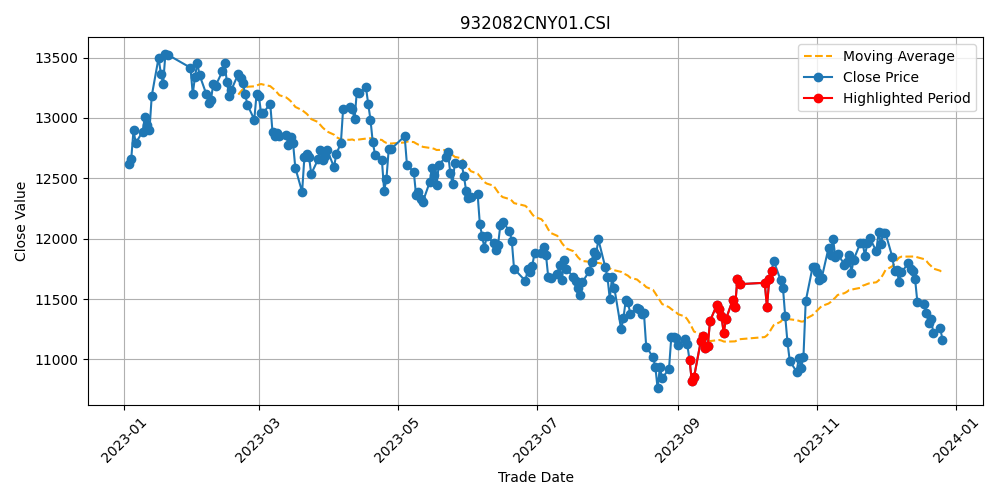

30
30
30
[(('2023-09-06', 2069.5034), ('2023-10-10', 2245.4037))]


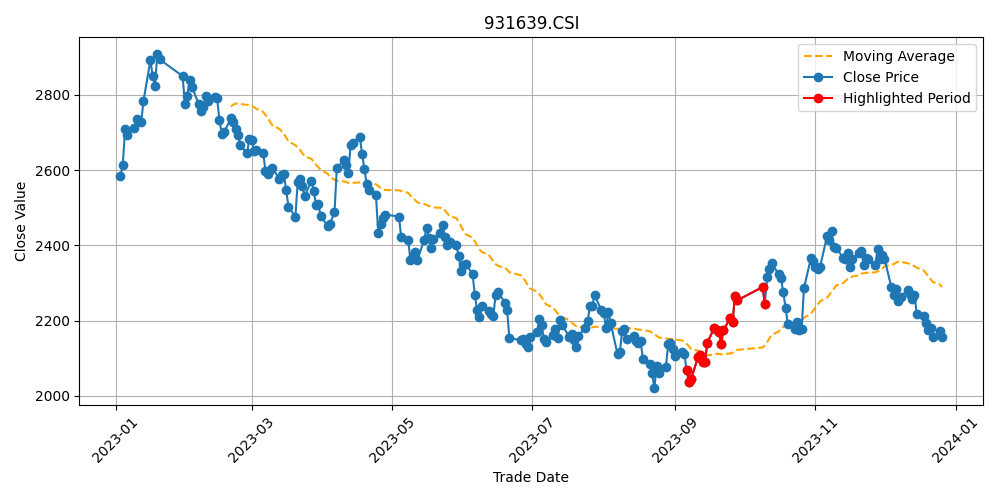

31
31
31
[(('2023-09-04', 757.6832), ('2023-09-14', 718.751))]


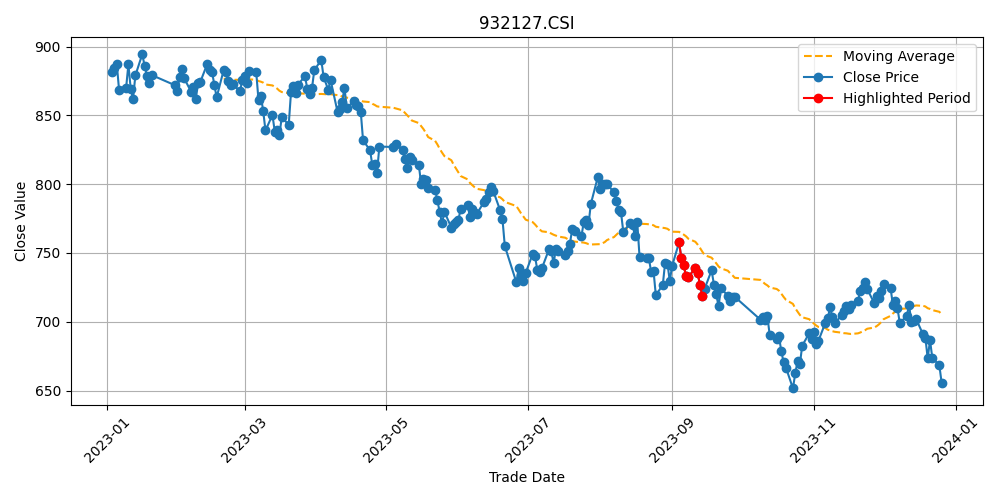

32
32
32
32
32
32
32
[(('2023-08-30', 1743.2766), ('2023-09-14', 1650.1627))]


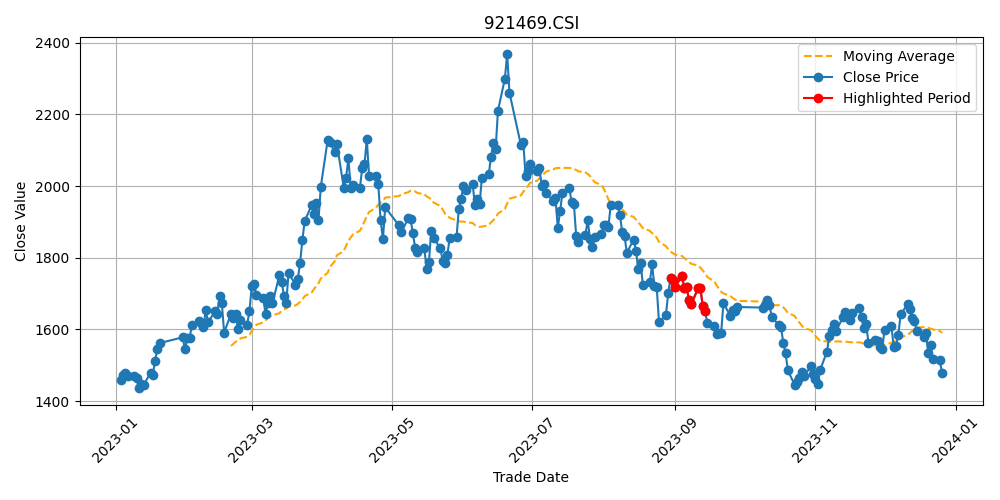

33
[(('2023-09-04', 3035.4541), ('2023-09-07', 2881.3006))]


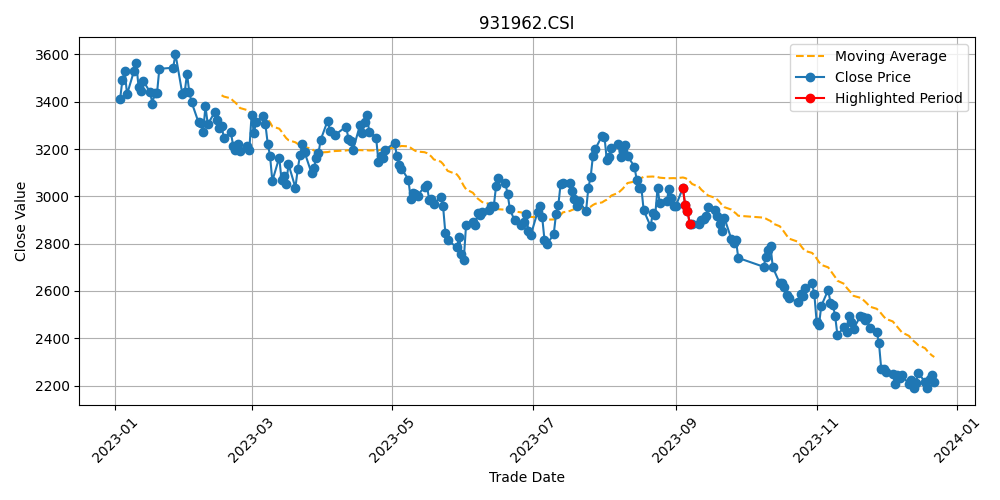

34
34
34
[(('2023-09-04', 16093.0572), ('2023-09-26', 15239.6417))]


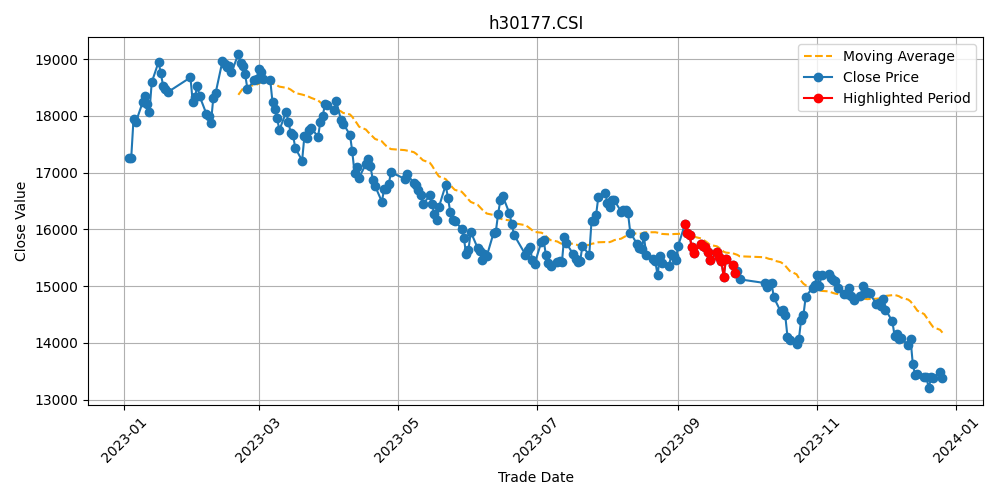

35
35
[(('2023-09-04', 3281.5904), ('2023-09-20', 3073.3374))]


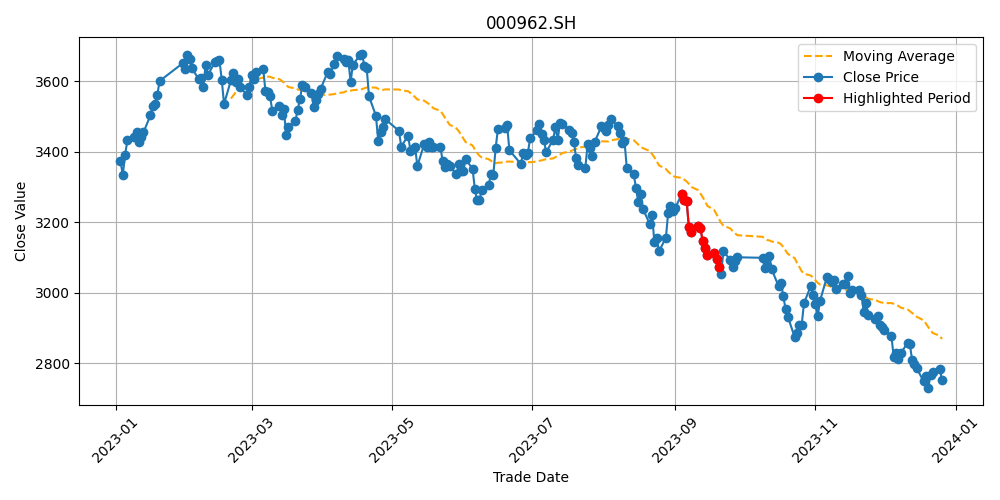

36
[(('2023-08-30', 2018.3507), ('2023-09-26', 1887.5196))]


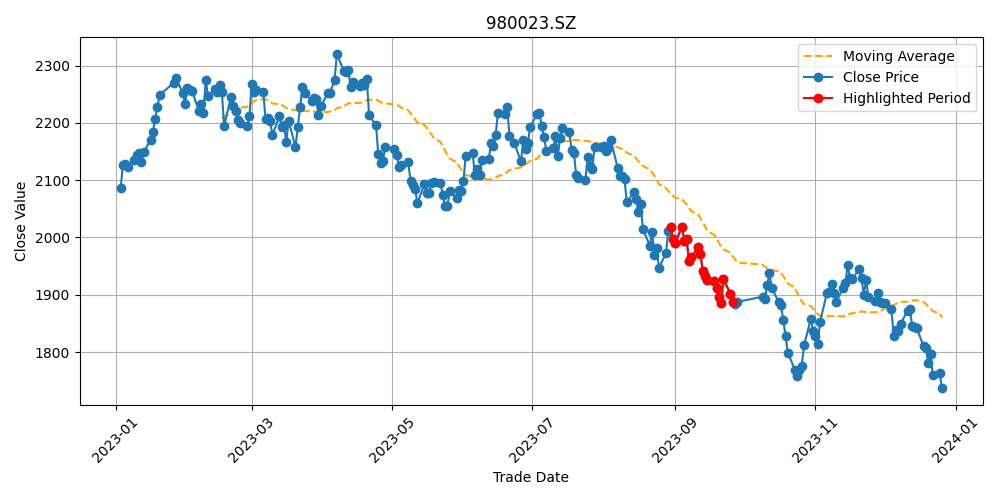

37
[(('2023-08-30', 2385.4656), ('2023-09-14', 2256.2925))]


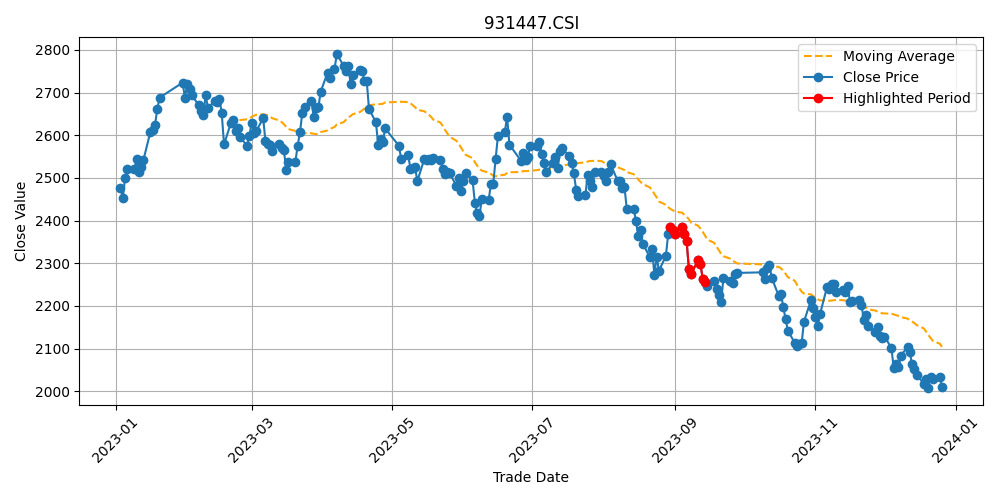

38
38
38
38
38
38
38
38
[(('2023-08-31', 3161.86), ('2023-09-26', 2949.3106))]


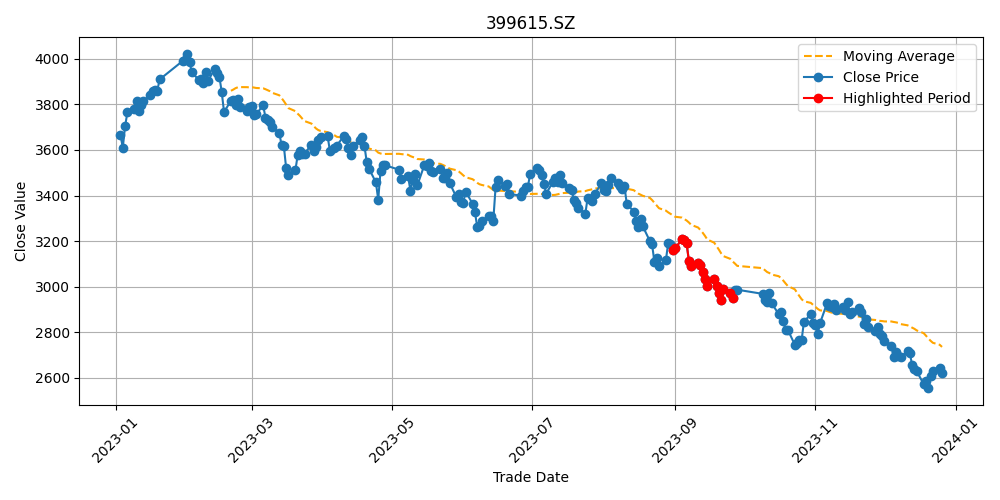

39
[(('2023-08-31', 3359.4857), ('2023-09-26', 3130.9229))]


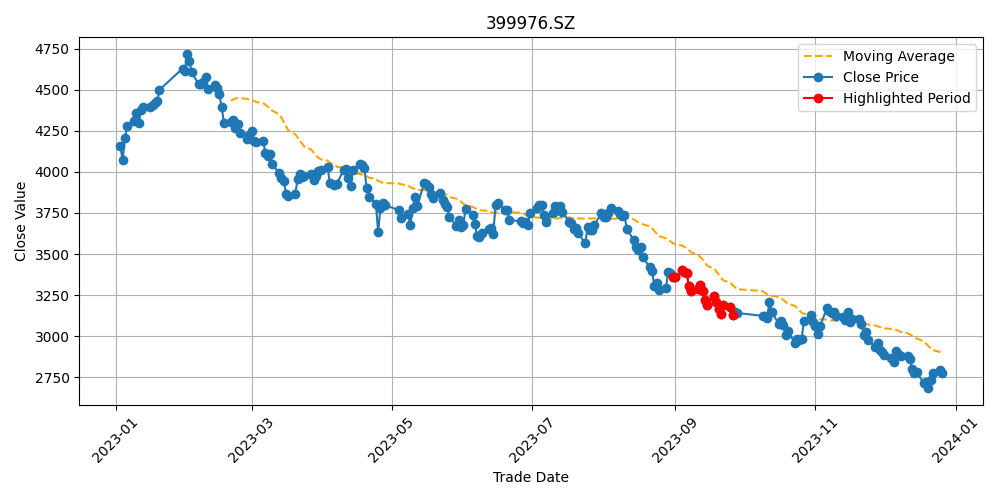

40
40
[(('2023-08-29', 3009.673), ('2023-09-26', 2703.3212))]


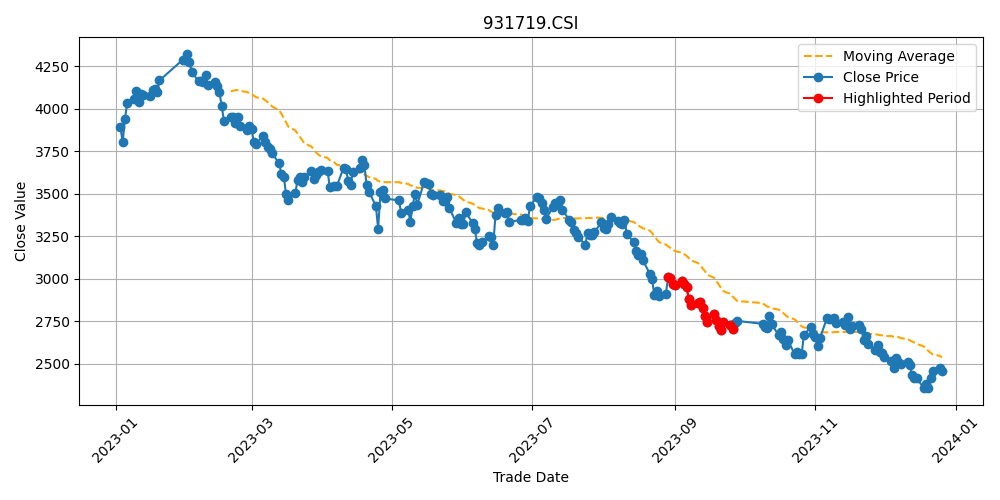

41
41
[(('2023-08-30', 2444.4896), ('2023-09-18', 2322.0992))]


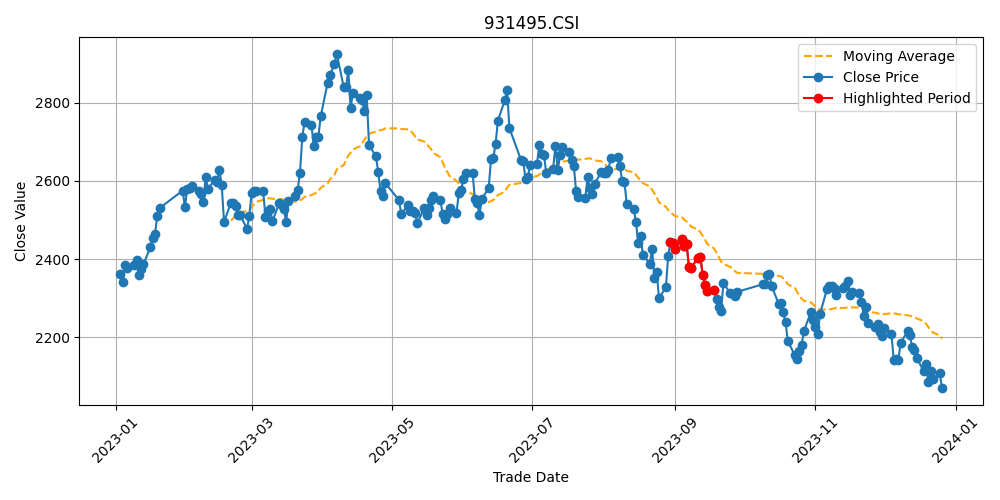

42
[(('2023-08-29', 1348.5298), ('2023-09-26', 1211.2088))]


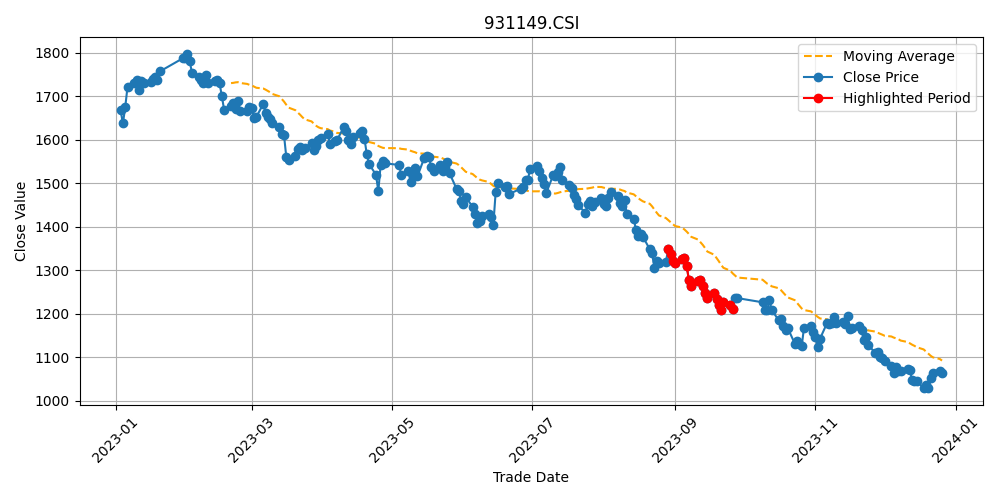

43
43
43
[(('2023-08-28', 26603.8053), ('2023-09-04', 27957.1656))]


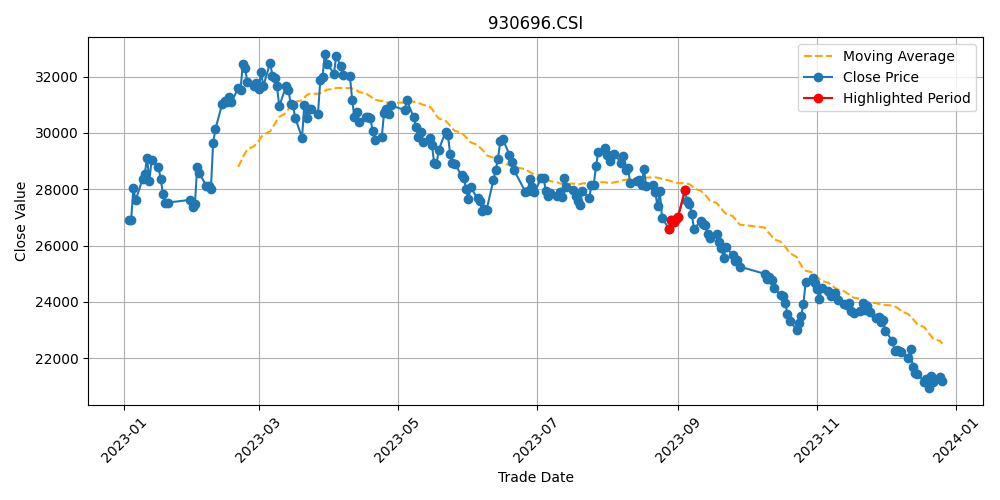

[(('2023-09-04', 27957.1656), ('2023-10-20', 23325.2914))]


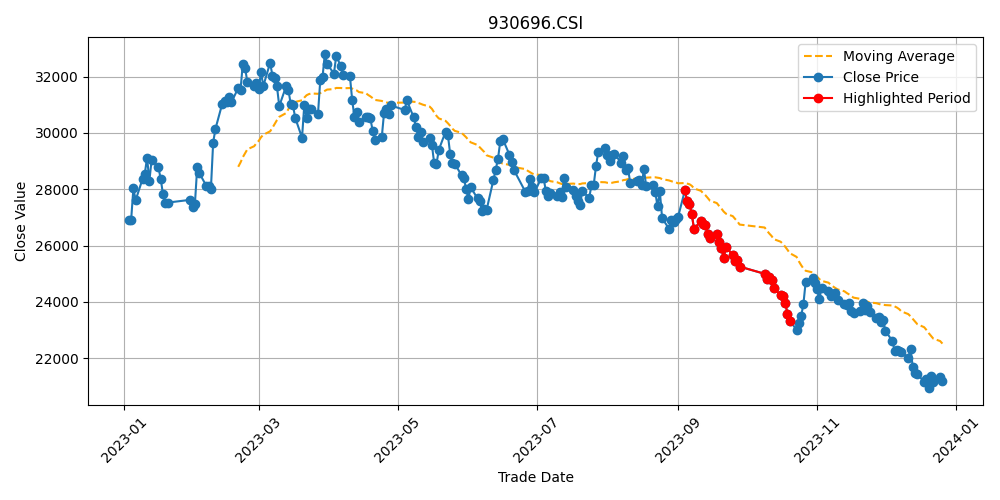

44
44
[(('2023-09-06', 2267.3012), ('2023-10-12', 2425.045))]


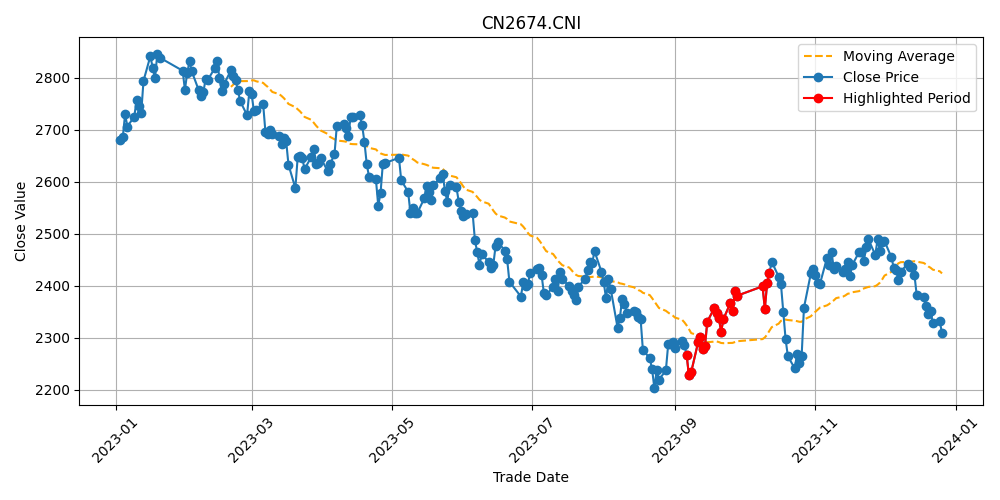

45
45
45
45
[(('2023-09-04', 2182.5817), ('2023-09-26', 2069.0887))]


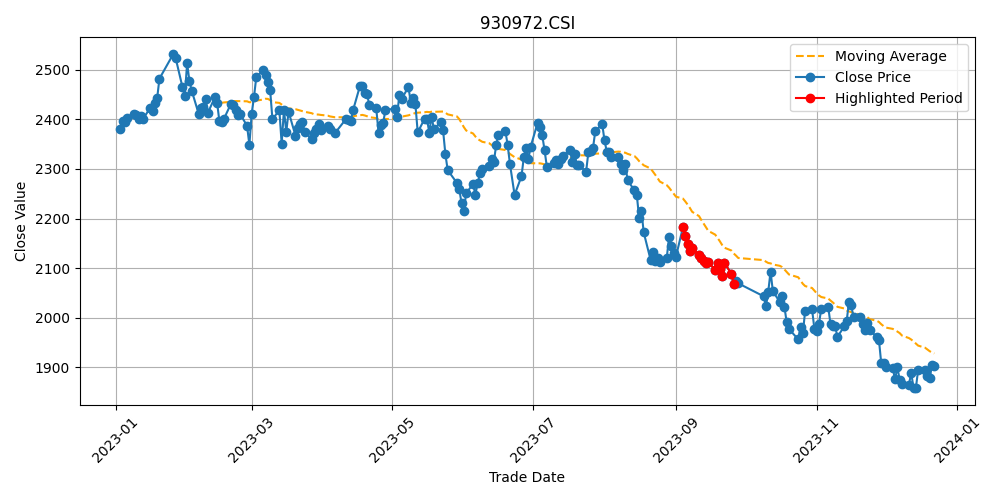

46
[(('2023-08-29', 1159.9732), ('2023-09-25', 1071.8606))]


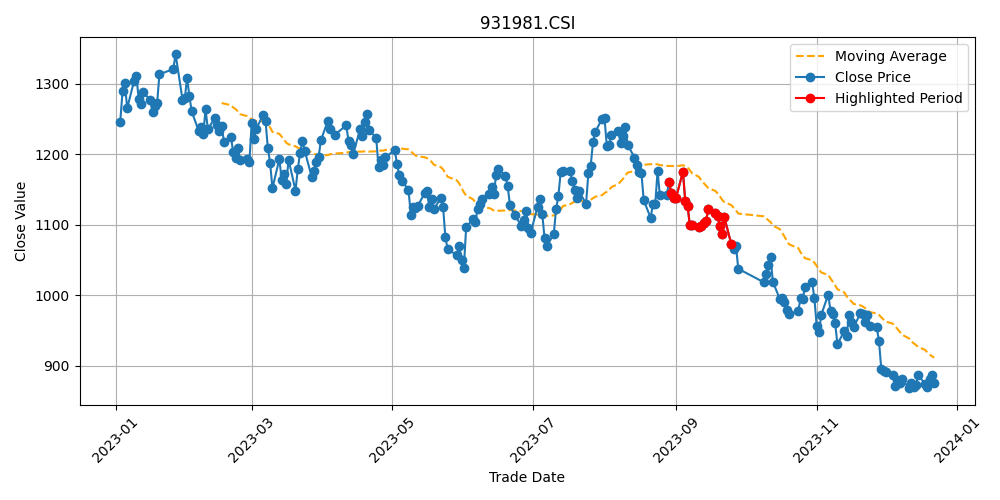

47
47
47
47
47
[(('2023-08-30', 4338.0173), ('2023-09-18', 4098.201))]


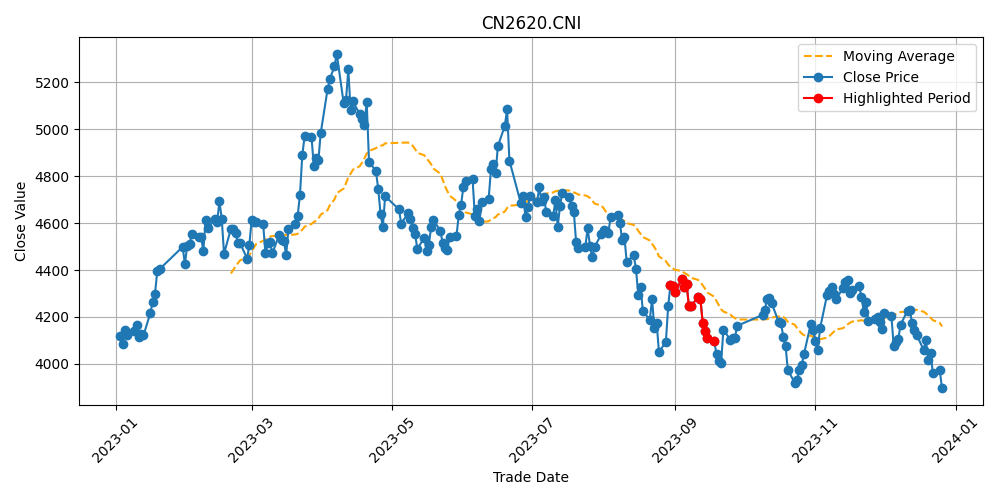

48
48
48
[(('2023-09-06', 1195.2475), ('2023-09-18', 1256.2213))]


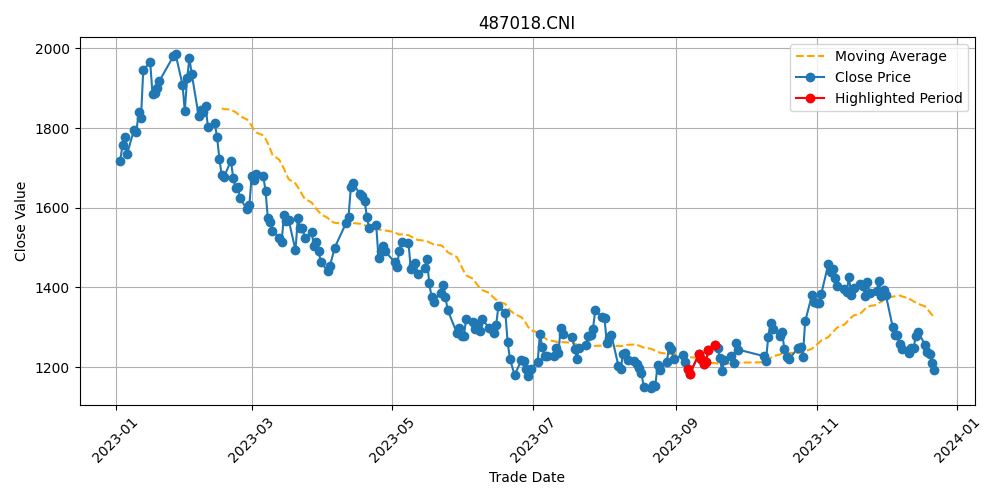

49
49
[(('2023-09-04', 9450.8579), ('2023-10-11', 8154.864))]


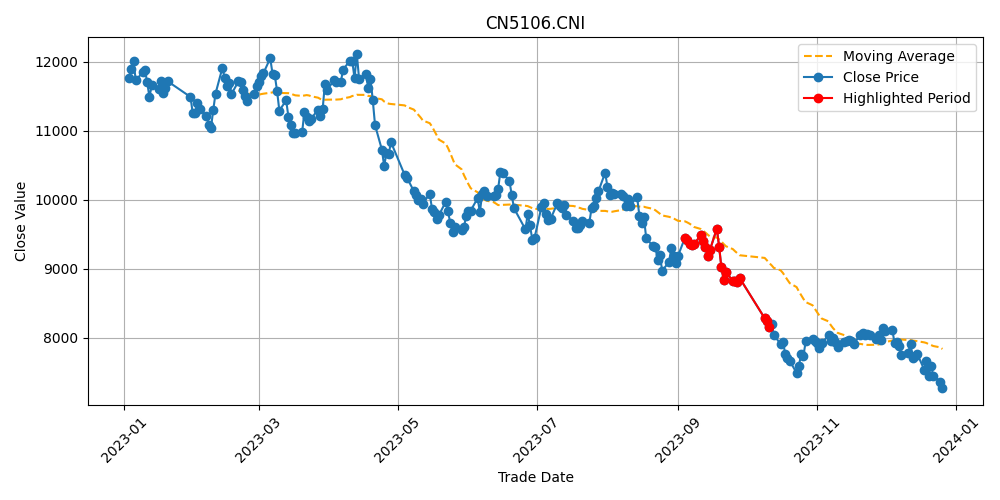

50
50
[(('2023-09-04', 2282.7363), ('2023-09-20', 2141.8491))]


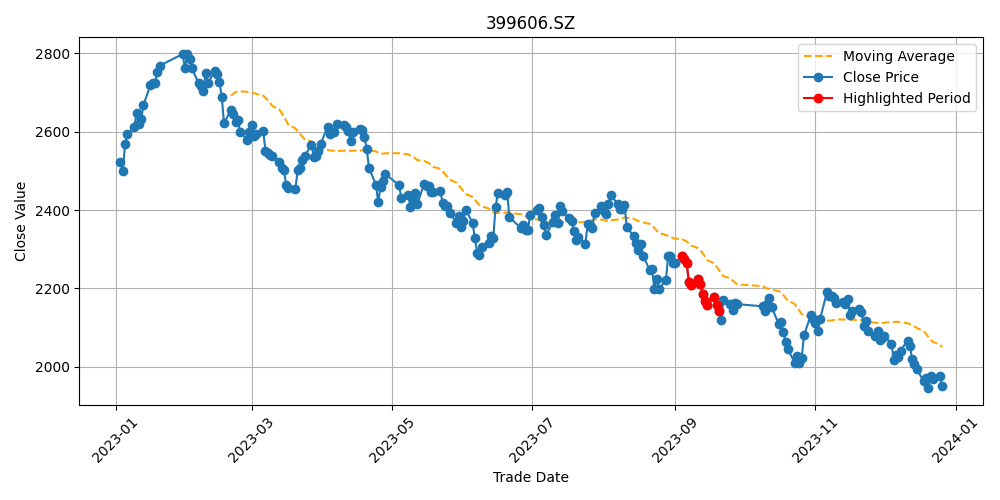

In [53]:
"""
Run
"""

count = 0
ird_codes = list(asset_dfs.keys())
while count <= 50:
    ird_code = random.choice(ird_codes)
    df = asset_dfs[ird_code]
    
    up, down = select_asset(ird_code=ird_code, df=df)
    
    if len(up) != 0 or len(down) != 0:
        count += 1

In [ ]:
# ird_codes = list(asset_dfs.keys())  # Get all the ird_code from the keys of the dictionary
# ird_code = random.choice(ird_codes)  # Randomly select one ird_code
# ird_code = 'h21014.CSI'
# df = asset_dfs[ird_code]

# date_record_self_up = find_turning_point_self(df, direction=1, fraction_movement=0.01, threshold_day=22, n_days=7)
# asset_whole_period_visualisation(ird_code, df, date_record=date_record_self_up)

# date_record_self_down = find_turning_point_self(df, direction=-1, fraction_movement=0.01, threshold_day=22, n_days=7)
# asset_whole_period_visualisation(ird_code, df, date_record=date_record_self_down)

# date_record_ma = find_turning_point_ma(df)
# asset_whole_period_visualisation(ird_code, df, date_record=date_record_ma)

# date_record_hma = find_turning_point_hma(df)
# asset_whole_period_visualisation(ird_code, df, date_record=date_record_hma)